In [133]:
import os
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics, neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn import svm

In [134]:
def readDataset():
    dataset = pd.read_json(r"D:\Semester6\NLP\A2\Project\Sarcasm-Detection-master\Sarcasm_Headlines_Dataset.json",lines = True)
    return dataset

In [135]:
def wordCloudGen(text):
                     
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(text) 
    
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show() 

In [136]:
def lemmatize_text(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text)]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

In [137]:
#Removing stop words
def remove_stopwords(text):
    stopword_list = nltk.corpus.stopwords.words('english')
    filtered_words = [word for word in nltk.word_tokenize(text) if word not in stopword_list]
    filtered_text = ' '.join(filtered_words)    
    return filtered_text

In [168]:
def KNN(dataset, p, noOfNeighbors, vector_type, metric=None):
    dataset["text_lemmatized"] = dataset["headline"].apply(lemmatize_text)
    dataset["filtered_text"] = dataset["text_lemmatized"].apply(remove_stopwords)
    
    print("**************************KNN Model**************************")
    
    #Splitting into train and test
    training_set, test_set, training_labels, test_labels = train_test_split(dataset["filtered_text"], dataset["is_sarcastic"], test_size=0.2, random_state=24)
    #creating a dataframe called df, which will store the predicted values for is_sarcastic, as obtained by this model
    training_setList = list(training_set)
    test_set = list(test_set)
    training_setList.extend(test_set)
    #print(training_setList)
    df = pd.DataFrame(training_setList, columns = ["Headlines"])
    
    trainingLabelsList = list(training_labels)
    
    #Calling the KNN classifier
    knn = neighbors.KNeighborsClassifier(n_neighbors=noOfNeighbors, weights='distance', algorithm='auto', metric=metric, p=p, n_jobs=1)
    #Using word counts
    if vector_type == 'BoW':
        vectorizer = CountVectorizer(analyzer='word', input='content')
        train_vec = vectorizer.fit_transform(training_set)
        test_vec = vectorizer.transform(test_set)
    #Using term frequency - Inverse document frequency
    elif vector_type == 'tfidf':
        vectorizer =  TfidfVectorizer(analyzer='word', input='content')
        train_vec = vectorizer.fit_transform(training_set)
        test_vec = vectorizer.transform(test_set)
    #Fitting the training model against training vectors as obtained above
    knn.fit(train_vec, training_labels)
    #predicting the test vectors outcomes
    predicted = knn.predict(test_vec)
    #print(predicted)
    l = []
    for i in range(0, len(test_set)):
        l.append(predicted[i])
    trainingLabelsList.extend(l)
    
    #Creating a dataframe which has the predicted output from this classifier, used to make a new dataset for the following model
    df1 = pd.DataFrame(trainingLabelsList, columns = ["is_sarcastic"])
    frames = [df, df1]
    res = pd.concat(frames, axis = 1)
    
    #Calculating the accuracy of this model
    acc = metrics.accuracy_score(test_labels, predicted)    
    print(res)
    print("Classification Report : \n")
    print(classification_report(test_labels,predicted))
    #Plotting the confusion matrix
    cm = confusion_matrix(test_labels, predicted)
    ax = plt.subplot()
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix');
    print(ax)
    print("=============================================================================================")
    print('Accuracy: KNN with {}, neighbors: {}, distance metric: {}  = {}'.format(vector_type, noOfNeighbors,metric, str(acc * 100) + '%'))
    print("----------------------------------------------------------------------------------------------")
    return res, acc*100

In [169]:
def SVM(a):
    a["text_lemmatized"] = a["Headlines"].apply(lemmatize_text)
    a["filtered_text"] = a["text_lemmatized"].apply(remove_stopwords)
    
    print("**************************SVM**************************")
    #Splitting into train and test
    training_set, test_set, training_labels, test_labels = train_test_split(a["filtered_text"], a["is_sarcastic"], test_size=0.2, random_state=24)
    #creating a dataframe called df, which will store the predicted values for is_sarcastic, as obtained by this model
    training_setList = list(training_set)
    test_set = list(test_set)
    training_setList.extend(test_set)
    trainingLabelsList = list(training_labels)
    df = pd.DataFrame(training_setList, columns = ["Headlines"])
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(training_set)
    Train_X_Tfidf = Tfidf_vect.transform(training_set)
    Test_X_Tfidf = Tfidf_vect.transform(test_set)
    # Classifier - Algorithm - SVM
    # fit the training dataset on the classifier
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(Train_X_Tfidf,training_labels)
    # predict the labels on validation dataset
    predictions_SVM = SVM.predict(Test_X_Tfidf)
    l = []
    for i in range(0, len(test_set)):
        l.append(predictions_SVM[i])
    trainingLabelsList.extend(l)
    #print(trainingLabelList)
    df1 = pd.DataFrame(trainingLabelsList, columns = ["is_sarcastic"])
    frames = [df, df1]
    result = pd.concat(frames, axis = 1)
    # Use accuracy_score function to get the accuracy
    print(result)
    print("Classification Report\n")
    print(classification_report(test_labels,predictions_SVM))
    #Plotting the confusion matrix
    cm = confusion_matrix(test_labels, predictions_SVM)
    ax = plt.subplot()
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix');
    print(ax)
    
    print("==============================================================================================")
    print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, test_labels)*100,"%")
    print("----------------------------------------------------------------------------------------------")
    return result, accuracy_score(predictions_SVM, test_labels)*100

In [170]:
def NaiveBayesClassifier(b):
    b["text_lemmatized"] = b["Headlines"].apply(lemmatize_text)
    b["filtered_text"] = b["text_lemmatized"].apply(remove_stopwords)
    
    print("**************************Naive Bayes**************************")
    #Splitting into train and test
    training_set, test_set, training_labels, test_labels = train_test_split(b["filtered_text"], b["is_sarcastic"], test_size=0.2, random_state=24)
    
    #creating a dataframe called df, which will store the predicted values for is_sarcastic, as obtained by this model
    training_setList = list(training_set)
    test_set = list(test_set)
    training_setList.extend(test_set)
    trainingLabelsList = list(training_labels)
    df = pd.DataFrame(training_setList, columns = ["Headlines"])
    
    #Bag of words
    vectorizer = CountVectorizer()
    bow_train_features = vectorizer.fit_transform(training_set)
    bow_test_features = vectorizer.transform(test_set)
    #building a naive bayes model
    mnb = MultinomialNB()
    mnb.fit(bow_train_features,training_labels)
    #prediction for the newly obtained dataset, using the NB classifier
    predictions = mnb.predict(bow_test_features)
    #Creating Dataframe which has a column "is_sarcastic", which has the predicted values for the same
    l = []
    for i in range(0, len(test_set)):
        l.append(predictions[i])
    trainingLabelsList.extend(l)
    df1 = pd.DataFrame(trainingLabelsList, columns = ["is_sarcastic"])
    frames = [df, df1]
    res1 = pd.concat(frames, axis = 1) #combining the two dataframes
    score = mnb.score(bow_test_features, test_labels)
    print(res1)
    print("Classification Report : \n")
    print(classification_report(test_labels,predictions))
    #Plotting the confusion matrix
    cm = confusion_matrix(test_labels, predictions)
    #cm = confusion_matrix(test_labels, predicted)
    ax = plt.subplot()
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix');
    print(ax)
    print("==============================================================================================")
    print("Bag of words accuracy for Naive Bayes : ",score*100)
    print("----------------------------------------------------------------------------------------------")
    return res1, score*100

In [171]:
def logisticReg(c):
    c["text_lemmatized"] = c["Headlines"].apply(lemmatize_text)
    c["filtered_text"] = c["text_lemmatized"].apply(remove_stopwords)
    
    print("**************************Logistic Regression**************************")
    #Splitting into train and test
    training_set, test_set, training_labels, test_labels = train_test_split(c["filtered_text"], c["is_sarcastic"], test_size=0.2, random_state=24)
    #creating a dataframe called df, which will store the predicted values for is_sarcastic, as obtained by this model
    training_setList = list(training_set)
    test_set = list(test_set)
    training_setList.extend(test_set)
    trainingLabelsList = list(training_labels)
    df = pd.DataFrame(training_setList, columns = ["Headlines"])
    
    # Extracting features by counting word counts
    countVector = CountVectorizer(min_df=2)
    countVector.fit_transform(training_set)
    trainFeatureSet = countVector.transform(training_set)
    testFeatureSet = countVector.transform(test_set)
    #building the logistic regression model
    logRegModel = LogisticRegression()
    logRegModel.fit(trainFeatureSet,training_labels)
    # Finding the predictions of test dataset
    predLogReg1 = logRegModel.predict(testFeatureSet)
    score = logRegModel.score(testFeatureSet,test_labels)
    
    l = []
    for i in range(0, len(test_set)):
        l.append(predLogReg1[i])
    trainingLabelsList.extend(l)
    df1 = pd.DataFrame(trainingLabelsList, columns = ["is_sarcastic"])
    frames = [df, df1]
    result = pd.concat(frames, axis = 1)
    print(result)
    print("Classification Report : \n")
    print(classification_report(test_labels,predLogReg1))
    #Plotting the confusion matrix
    cm = confusion_matrix(test_labels, predLogReg1)

    ax = plt.subplot()
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix');
    print(ax)
    
    print("==============================================================================================")
    print("Approximate Accuracy (with countVectorizer) for Logistic Regression : ", score*100,"%")
    print("----------------------------------------------------------------------------------------------")
    
    return result,score*100
    

In [172]:
def visualisation(accuracyKNN, accuracySVM, accuracyNBC, accuracyLR):
    left = [1, 2, 3, 4]
    X = ["KNN", "SVM", "Naive Bayes", "Logistic Regression"]
    Y = [accuracyKNN, accuracySVM, accuracyNBC, accuracyLR]
    
   
    plt.bar(left, Y, tick_label = X, 
        width = 0.8, color = ['red', 'green','blue','yellow'])
    
    plt.xlabel('Classifier') 
    
    # naming the y axis 
    plt.ylabel('Accuracies') 
  
    # giving a title to my graph 
    plt.title('Accuracy Comparison') 
  
    # function to show the plot 
    plt.show() 

----------------------------------Original Dataset----------------------------------
------------------------------------------------------------------------------------
                                            article_link  \
0      https://www.huffingtonpost.com/entry/versace-b...   
1      https://www.huffingtonpost.com/entry/roseanne-...   
2      https://local.theonion.com/mom-starting-to-fea...   
3      https://politics.theonion.com/boehner-just-wan...   
4      https://www.huffingtonpost.com/entry/jk-rowlin...   
...                                                  ...   
26704  https://www.huffingtonpost.com/entry/american-...   
26705  https://www.huffingtonpost.com/entry/americas-...   
26706  https://www.huffingtonpost.com/entry/reparatio...   
26707  https://www.huffingtonpost.com/entry/israeli-b...   
26708  https://www.huffingtonpost.com/entry/gourmet-g...   

                                                headline  is_sarcastic  
0      former versace store clerk su

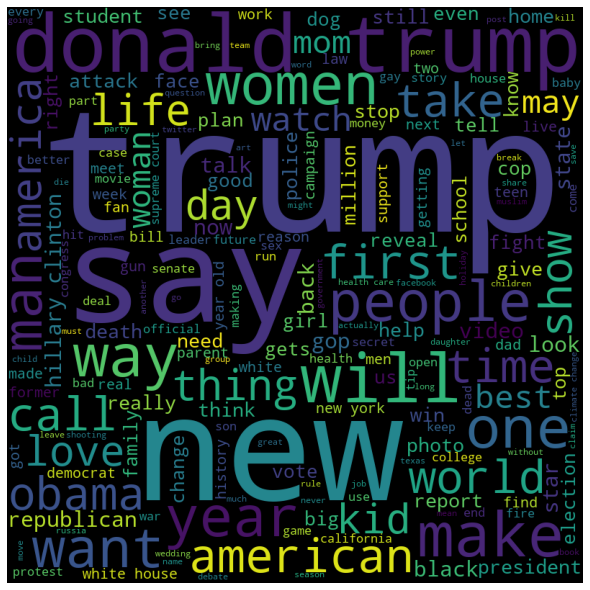

Non - Sarcastic Headline : 


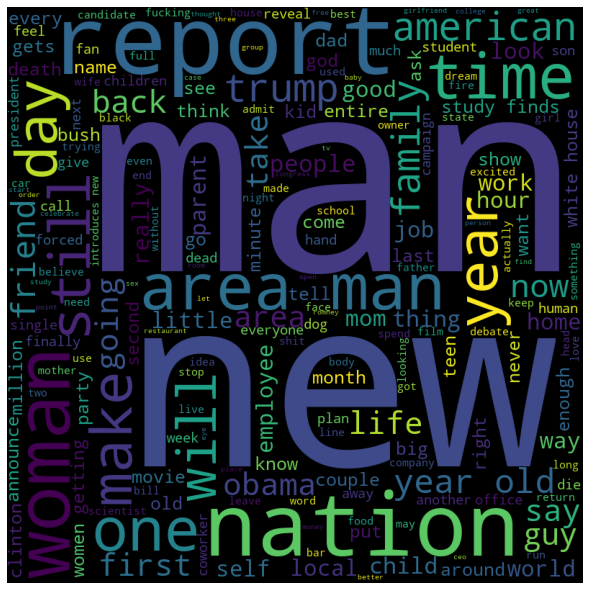

**************************KNN Model**************************
                                               Headlines  is_sarcastic
0              became middle-aged woman us baby talk dog             0
1      read letter barack obama left donald trump upo...             0
2        kim cattrall 's missing brother found dead home             0
3      former mexican president trump : 'your mouth f...             0
4      stephen breyer set supreme court record gavel ...             1
...                                                  ...           ...
26704  buoyant force area object equal weight water d...             1
26705                          avoiding auto repair scam             0
26706  president trump , n't hurt american sabotaging...             0
26707  meeting jon snow irl apparently like seeing 'm...             0
26708  patton oswalt want know 'you 're f**king child...             0

[26709 rows x 2 columns]
Classification Report : 

              precision    recall 

C:\Users\User\Anaconda3\envs\trial\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


**************************Naive Bayes**************************
                                               Headlines  is_sarcastic
0      area woman 's type tall , athletic men already...             1
1      president trump , n't hurt american sabotaging...             0
2      supreme court foreshadows big constitutional r...             0
3                          news roundup august 23 , 2017             0
4         actor matthew mcconaughey agrees star whatever             1
...                                                  ...           ...
26704  tr*mp effect : transgender folk ' mental healt...             0
26705                      7 simple habit adopt keep fit             0
26706  arizona republican want prosecute protester wa...             0
26707  end international drug war control afghan narc...             0
26708          's terrorist 's son became peace activist             0

[26709 rows x 2 columns]
Classification Report : 

              precision    recal

C:\Users\User\Anaconda3\envs\trial\lib\site-packages\ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


**************************Logistic Regression**************************
                                               Headlines  is_sarcastic
0      bernie sander ' health care bill huge win abor...             0
1              2018 winter olympics pyeongchang , number             0
2      new hampshire primary excites tiny percentage ...             0
3      doe draymond green take game next level ? tuni...             0
4             trump wo n't endorse paul ryan john mccain             0
...                                                  ...           ...
26704  'scandal ' 'house card , ' political drama suf...             0
26705                     mom drove kid ocean give birth             0
26706  cookie johnson reveals led secret 2-week separ...             0
26707                 trauma followed surprise pregnancy             0
26708       story lamar odom 's kindness pour around nba             0

[26709 rows x 2 columns]
Classification Report : 

              precision 

C:\Users\User\Anaconda3\envs\trial\lib\site-packages\ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


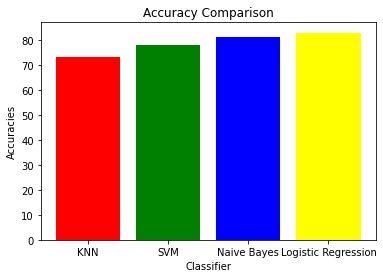

None


In [173]:
from wordcloud import WordCloud, STOPWORDS 

if __name__ == "__main__":
    dataset = readDataset()
    headlines = list(dataset["headline"])
    sarcasticVal = list(dataset["is_sarcastic"])
    print("----------------------------------Original Dataset----------------------------------")
    print("------------------------------------------------------------------------------------")
    print(dataset)
    stopwords = set(STOPWORDS)
    sarcasmTxt = " "
    nonSarcasmTxt = " "
    for val in range(0,len(headlines)):
        tokens = headlines[val].split()
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower()
        if sarcasticVal[val] == 0:
            sarcasmTxt += " ".join(tokens)+" "
        else:
            nonSarcasmTxt += " ".join(tokens)+" "
    print("Sarcastic Headline : ")
    wordCloudGen(sarcasmTxt)
    print("Non - Sarcastic Headline : ")
    wordCloudGen(nonSarcasmTxt)
            
    a = KNN(dataset,2,7,'BoW','cosine')
    accuracyKNN = a[1]
    b = SVM(a[0])
    accuracySVM = b[1]
    c = NaiveBayesClassifier(b[0])
    accuracyNBC = c[1]
    d = logisticReg(c[0])
    accuracyLR = d[1]
    
    e = visualisation(accuracyKNN, accuracySVM, accuracyNBC, accuracyLR)
    print(e)
    
    